In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

## Data loading and sanity checks

In [3]:
df = pd.read_csv('data\Life-Expectancy-Data-Updated.csv')

# Simple renaming to improve readability
df=df.rename(columns={'Thinness_ten_nineteen_years':'Thinness (10-19 years)',\
                      'Thinness_five_nine_years':'Thinness (5-9 years)', \
                      'Economy_status_Developed' : 'Developed', \
                      'Economy_status_Developing' : 'Developing'                  
                     })

In [4]:
df.columns

Index(['Country', 'Region', 'Year', 'Infant_deaths', 'Under_five_deaths',
       'Adult_mortality', 'Alcohol_consumption', 'Hepatitis_B', 'Measles',
       'BMI', 'Polio', 'Diphtheria', 'Incidents_HIV', 'GDP_per_capita',
       'Population_mln', 'Thinness (10-19 years)', 'Thinness (5-9 years)',
       'Schooling', 'Developed', 'Developing', 'Life_expectancy'],
      dtype='object')

In [5]:
df.head()

,Country,Region,Year,Infant_deaths,Under_five_deaths,Adult_mortality,Alcohol_consumption,Hepatitis_B,Measles,BMI,...,Diphtheria,Incidents_HIV,GDP_per_capita,Population_mln,Thinness (10-19 years),Thinness (5-9 years),Schooling,Developed,Developing,Life_expectancy
0,Turkiye,Middle East,2015,11.1,13.0,105.8240,1.32,97,65,27.8,...,97,0.08,11006,78.53,4.9,4.8,7.8,0,1,76.5
1,Spain,European Union,2015,2.7,3.3,57.9025,10.35,97,94,26.0,...,97,0.09,25742,46.44,0.6,0.5,9.7,1,0,82.8
2,India,Asia,2007,51.5,67.9,201.0765,1.57,60,35,21.2,...,64,0.13,1076,1183.21,27.1,28.0,5.0,0,1,65.4
3,Guyana,South America,2006,32.8,40.5,222.1965,5.68,93,74,25.3,...,93,0.79,4146,0.75,5.7,5.5,7.9,0,1,67.0
4,Israel,Middle East,2012,3.4,4.3,57.9510,2.89,97,89,27.0,...,94,0.08,33995,7.91,1.2,1.1,12.8,1,0,81.7


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2864 entries, 0 to 2863
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Country                 2864 non-null   object 
 1   Region                  2864 non-null   object 
 2   Year                    2864 non-null   int64  
 3   Infant_deaths           2864 non-null   float64
 4   Under_five_deaths       2864 non-null   float64
 5   Adult_mortality         2864 non-null   float64
 6   Alcohol_consumption     2864 non-null   float64
 7   Hepatitis_B             2864 non-null   int64  
 8   Measles                 2864 non-null   int64  
 9   BMI                     2864 non-null   float64
 10  Polio                   2864 non-null   int64  
 11  Diphtheria              2864 non-null   int64  
 12  Incidents_HIV           2864 non-null   float64
 13  GDP_per_capita          2864 non-null   int64  
 14  Population_mln          2864 non-null   

In [7]:
df.describe()

,Year,Infant_deaths,Under_five_deaths,Adult_mortality,Alcohol_consumption,Hepatitis_B,Measles,BMI,Polio,Diphtheria,Incidents_HIV,GDP_per_capita,Population_mln,Thinness (10-19 years),Thinness (5-9 years),Schooling,Developed,Developing,Life_expectancy
count,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000
mean,2007.500000,30.363792,42.938268,192.251775,4.820882,84.292598,77.344972,25.032926,86.499651,86.271648,0.894288,11540.924930,36.675915,4.865852,4.899825,7.632123,0.206704,0.793296,68.856075
std,4.610577,27.538117,44.569974,114.910281,3.981949,15.995511,18.659693,2.193905,15.080365,15.534225,2.381389,16934.788931,136.485867,4.438234,4.525217,3.171556,0.405012,0.405012,9.405608
min,2000.000000,1.800000,2.300000,49.384000,0.000000,12.000000,10.000000,19.800000,8.000000,16.000000,0.010000,148.000000,0.080000,0.100000,0.100000,1.100000,0.000000,0.000000,39.400000
25%,2003.750000,8.100000,9.675000,106.910250,1.200000,78.000000,64.000000,23.200000,81.000000,81.000000,0.080000,1415.750000,2.097500,1.600000,1.600000,5.100000,0.000000,1.000000,62.700000
50%,2007.500000,19.600000,23.100000,163.841500,4.020000,89.000000,83.000000,25.500000,93.000000,93.000000,0.150000,4217.000000,7.850000,3.300000,3.400000,7.800000,0.000000,1.000000,71.400000
75%,2011.250000,47.350000,66.000000,246.791375,7.777500,96.000000,93.000000,26.400000,97.000000,97.000000,0.460000,12557.000000,23.687500,7.200000,7.300000,10.300000,0.000000,1.000000,75.400000
max,2015.000000,138.100000,224.900000,719.360500,17.870000,99.000000,99.000000,32.100000,99.000000,99.000000,21.680000,112418.000000,1379.860000,27.700000,28.600000,14.100000,1.000000,1.000000,83.800000


In [8]:
df.isnull().sum()

Country                   0
Region                    0
Year                      0
Infant_deaths             0
Under_five_deaths         0
Adult_mortality           0
Alcohol_consumption       0
Hepatitis_B               0
Measles                   0
BMI                       0
Polio                     0
Diphtheria                0
Incidents_HIV             0
GDP_per_capita            0
Population_mln            0
Thinness (10-19 years)    0
Thinness (5-9 years)      0
Schooling                 0
Developed                 0
Developing                0
Life_expectancy           0
dtype: int64

**Confirm that Developed and Developing are complements of each other**

In [10]:
(df['Developed']+df['Developing']==1).sum()==df.shape[0]

True

In [11]:
df=df.drop('Developing', axis=1)

In [12]:
df_developed = df[df['Developed']==1]
df_developed = df_developed.drop('Developed', axis=1)

df_developing = df[df['Developed']==0]
df_developing = df_developing.drop('Developed', axis=1)

df_developed.head()

,Country,Region,Year,Infant_deaths,Under_five_deaths,Adult_mortality,Alcohol_consumption,Hepatitis_B,Measles,BMI,Polio,Diphtheria,Incidents_HIV,GDP_per_capita,Population_mln,Thinness (10-19 years),Thinness (5-9 years),Schooling,Life_expectancy
1,Spain,European Union,2015,2.7,3.3,57.9025,10.35,97,94,26.0,97,97,0.09,25742,46.44,0.6,0.5,9.7,82.8
4,Israel,Middle East,2012,3.4,4.3,57.9510,2.89,97,89,27.0,94,94,0.08,33995,7.91,1.2,1.1,12.8,81.7
7,Hungary,European Union,2000,8.7,10.1,192.9690,12.23,88,99,25.9,99,99,0.08,8971,10.21,2.3,2.3,10.2,71.2
11,Malta,European Union,2007,6.0,6.8,58.0185,7.47,82,77,27.1,76,74,0.08,19338,0.41,0.7,0.7,9.9,79.8
14,Switzerland,Rest of Europe,2006,4.2,4.9,63.2435,10.24,88,71,25.0,94,94,0.08,79368,7.48,0.6,0.4,12.3,81.5


**Check number of developed and developing countries**

In [14]:
n_developed = len(df_developed['Country'].unique())
n_developing = len(df_developing['Country'].unique())
print(f'Number of distinct developed countries: {n_developed}')
print(f'Number of distinct developing countries: {n_developing}')
print(f'Total number of distinct countries: {n_developed + n_developing}')

Number of distinct developed countries: 37
Number of distinct developing countries: 142
Total number of distinct countries: 179


**Confirm that all countries have entries for every year**

In [16]:
np.sort(df['Year'].unique())

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015], dtype=int64)

In [17]:
df_subset = df[['Year', 'Country']]
grouped=df_subset.groupby(['Country']).count()
# grouped.pivot(index='Country', columns='Year')
grouped[grouped['Year']!=16].shape[0]==0

True

## Trend Analysis

In [17]:
def pivot_table_op(df, groupBy, value, fun):
    '''Produces a pivot table of specified value grouped by a column'''  
    df_subset = df[['Year', groupBy, value]]
    grouped=fun(df_subset.groupby([groupBy, 'Year'])).reset_index()
    return grouped.pivot(index='Year', columns=groupBy, values=value)

We see overall all regions have increasing life expectancy with Africa considerably below the rest

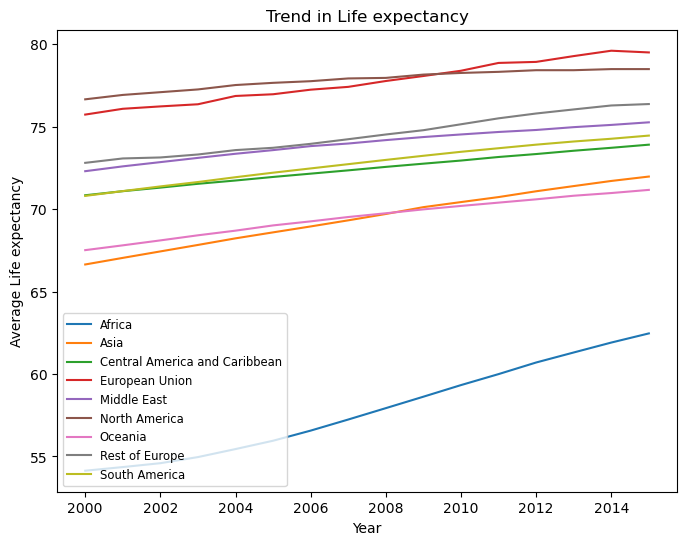

In [19]:
pivot = pivot_table_op(df, 'Region', 'Life_expectancy', lambda x: x.mean())
plt.figure(figsize=(8,6))
for col in pivot.columns:
    plt.plot(pivot.index, pivot[col], label=col)

plt.xlabel('Year')
plt.ylabel('Average Life expectancy')
plt.title('Trend in Life expectancy')
plt.legend(fontsize='small')
plt.show()

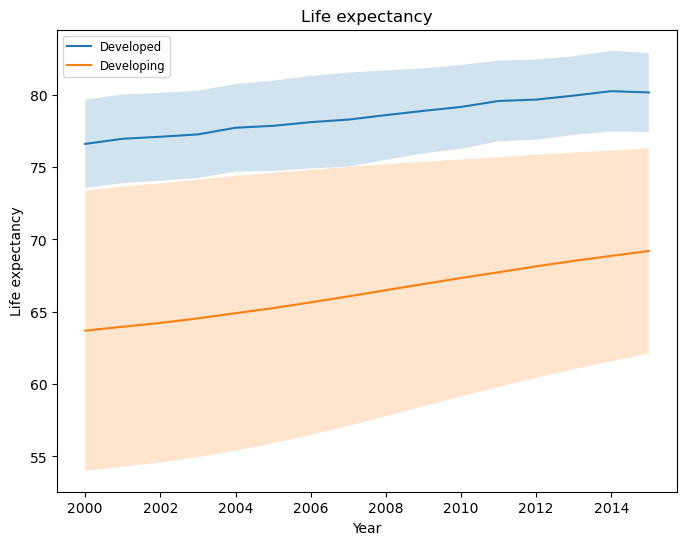

In [20]:
pivot_mean = pivot_table_op(df, 'Developed', 'Life_expectancy', lambda x: x.mean())
pivot_std = pivot_table_op(df, 'Developed', 'Life_expectancy', lambda x: x.std())

plt.figure(figsize=(8,6))
mean_developed = pivot_mean[int(True)]
std_developed = pivot_std[int(True)]
plt.plot(pivot_mean.index, mean_developed, label='Developed')
plt.fill_between(pivot_std.index, mean_developed - std_developed, mean_developed + std_developed, alpha=0.2)

mean_developing = pivot_mean[int(False)]
std_developing = pivot_std[int(False)]
plt.plot(pivot_mean.index, mean_developing, label='Developing')
plt.fill_between(pivot_std.index, mean_developing - std_developing, mean_developing + std_developing, alpha=0.2)

plt.xlabel('Year')
plt.ylabel('Life expectancy')
plt.title('Life expectancy')
plt.legend(fontsize='small')
plt.show()

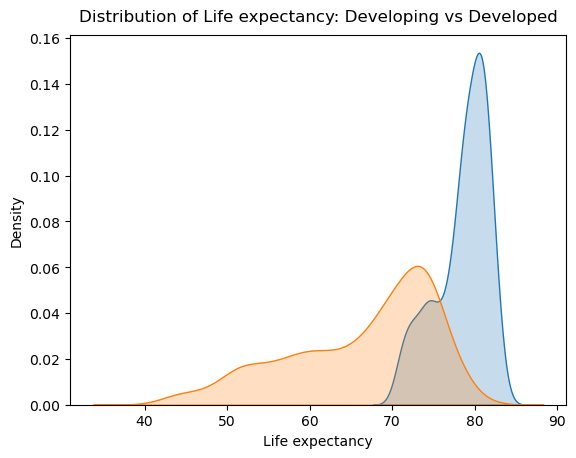

In [21]:
ax = sns.kdeplot(df_developed, x="Life_expectancy", fill=True, legend=True)
ax = sns.kdeplot(df_developing, x="Life_expectancy", fill=True, legend=True)
# sns.move_legend(ax, "upper left")
ax.set_title("Distribution of Life expectancy: Developing vs Developed", pad=10)
ax.set_xlabel("Life expectancy")     
plt.show()

## Outliers

In [23]:
def find_outliers(pivot, threshold):
    output = []
    trend = pivot.mean(axis=1)
    for col in pivot.columns:
        corr = np.corrcoef(pivot[col], trend)
        output.append([col, corr[0,1]])
    
    corr_df = pd.DataFrame(output, columns=['Country' ,'Correlation'])
    corr_df.sort_values('Correlation', inplace=True)
    return corr_df[corr_df['Correlation']<threshold]

def plot_outliers(pivot, outliers):
    outliers = pivot[outliers['Country']]
    
    plt.figure(figsize=(8,6))
    for col in outliers.columns:
        plt.plot(outliers.index, outliers[col], label=col)
    
    trend = pivot.mean(axis=1)
    plt.plot(trend.index, trend, '--', label='Average Trend')
    plt.legend()
    plt.show()
    

In [24]:
pivot = pivot_table_op(df_developed, 'Country', 'Life_expectancy', lambda x: x.mean())
outliers = find_outliers(pivot, threshold=0)
outliers

,Country,Correlation


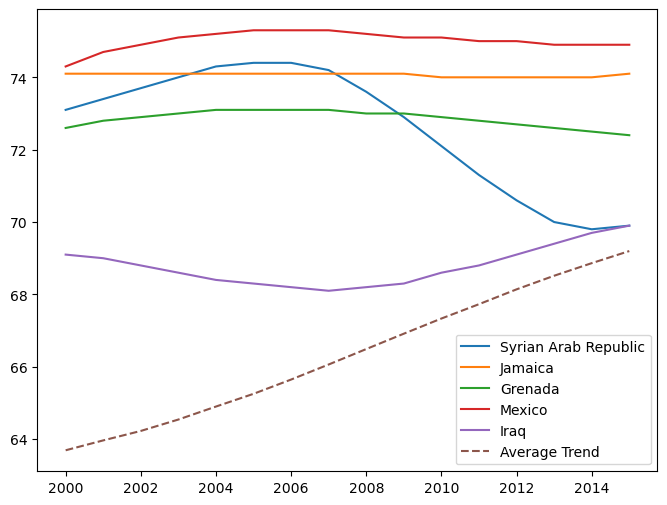

In [25]:
pivot = pivot_table_op(df_developing, 'Country', 'Life_expectancy', lambda x: x.mean())
outliers = find_outliers(pivot, threshold=0.5)
plot_outliers(pivot, outliers)

## Correlation analysis

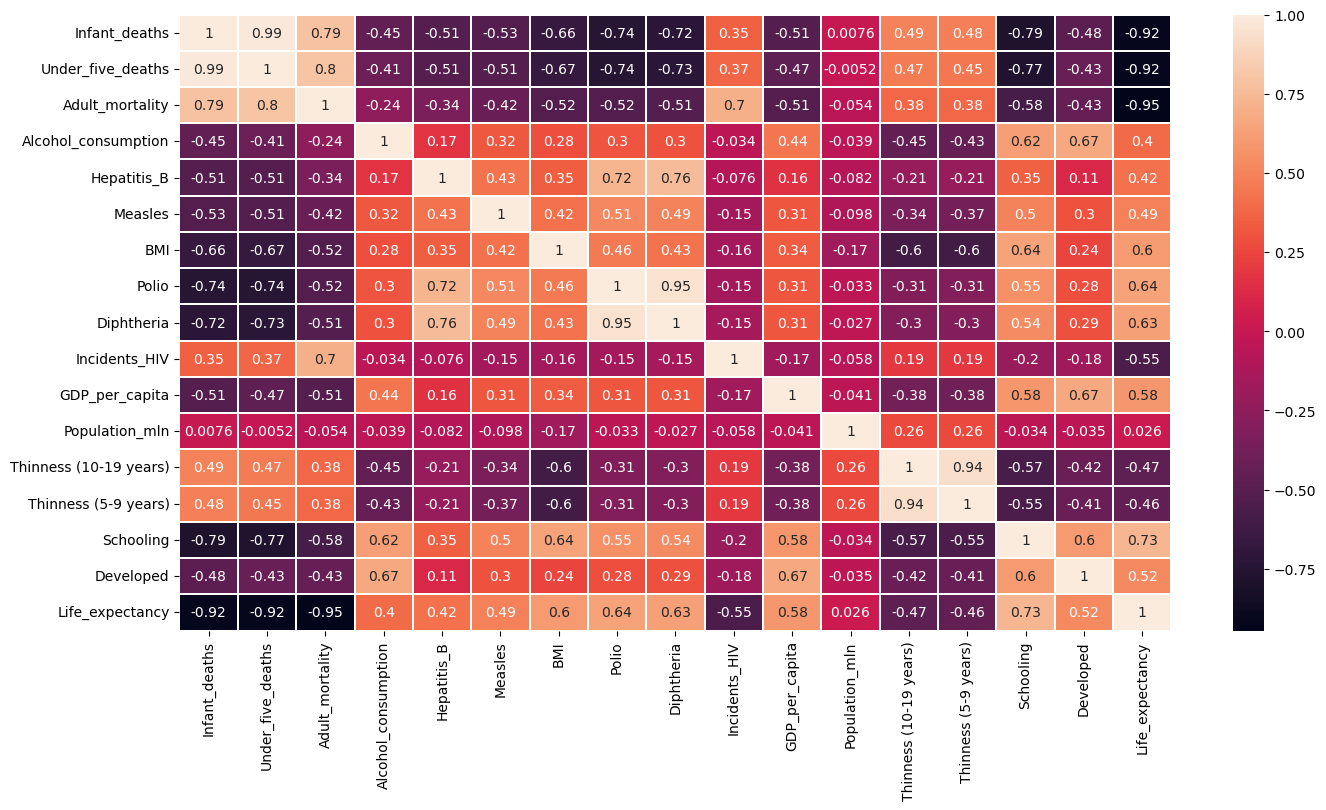

In [27]:
def remove_small_entries(df, tol=0.5):
    def f(x): return 0.0 if(abs(x)<tol) else x
    return df.map(f)

def corr_heatmap(df, remove_cols):
    X = df.drop(remove_cols, axis=1)
    X_scaled = StandardScaler().fit_transform(X)
    X_scaled=pd.DataFrame(X_scaled, columns=X.columns)
    correlation = X_scaled.corr()
    # correlation = remove_small_entries(correlation)
    fig=plt.figure(figsize=(16,8))
    sns.heatmap(correlation, annot=True, linewidths=0.25)

corr_heatmap(df, ['Country', 'Region', 'Year'])

We note the following are highly correlated: 
- Infant_deaths, Under_five_deaths, and Adult_mortality
- Diphtheria and Polio
- Thinness (5-9 years) and Thinness (10-19 years)

We therefore drop: Infant_deaths, Under_five_deaths, Diphtheria, and Thinness (5-9 years)

In [29]:
df_reduced = df.drop(['Infant_deaths', 'Under_five_deaths', 'Diphtheria', 'Thinness (5-9 years)'], axis=1)

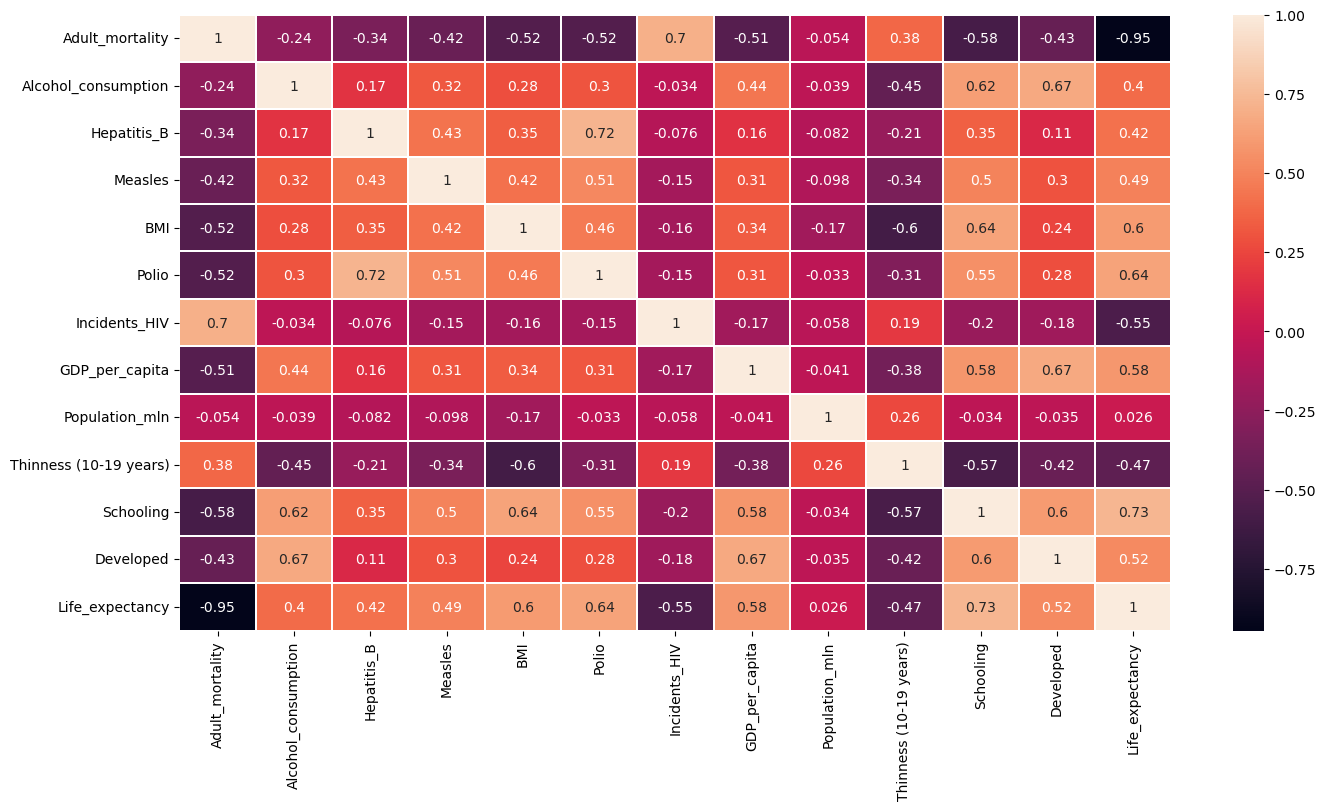

In [30]:
corr_heatmap(df_reduced, ['Country', 'Region', 'Year'])

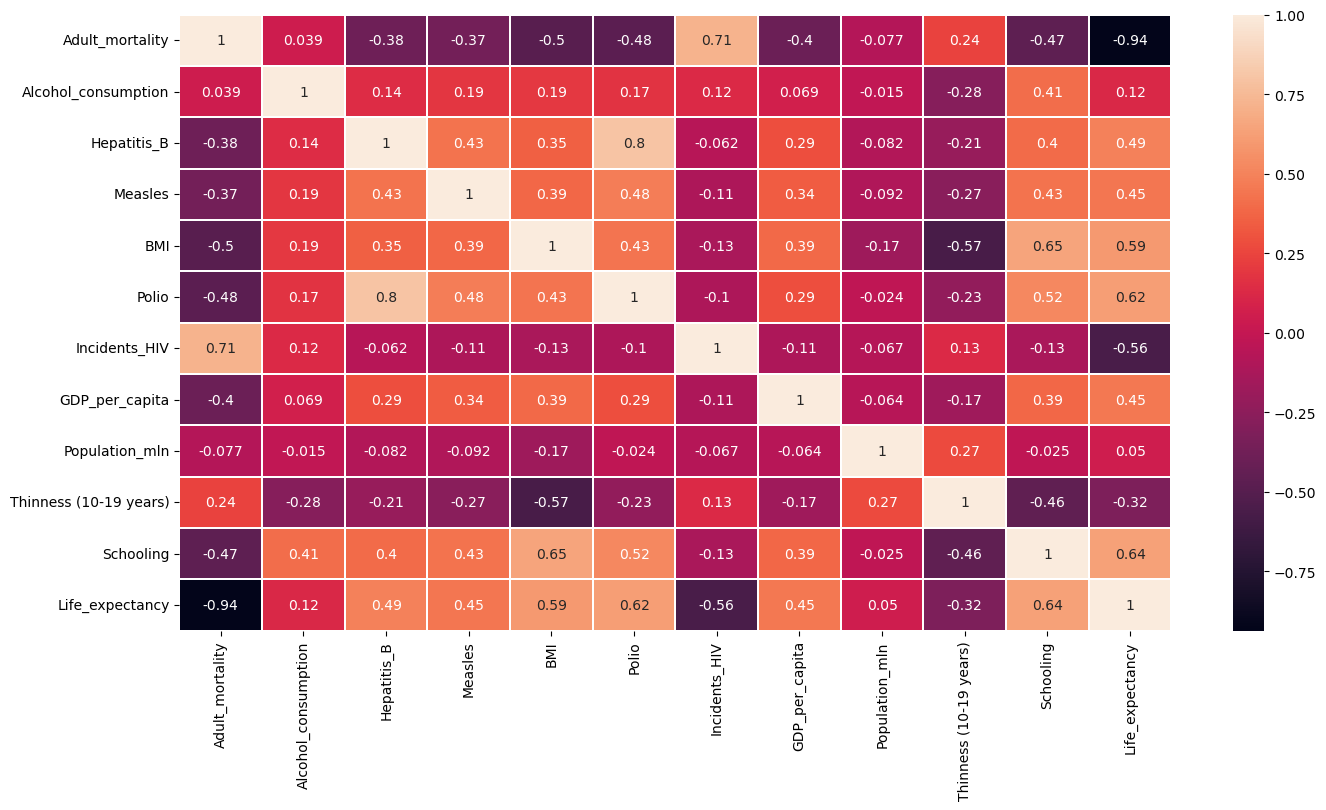

In [31]:
# Developing
corr_heatmap(df_reduced[df_reduced['Developed']==0].drop('Developed', axis=1), ['Country', 'Region', 'Year'])

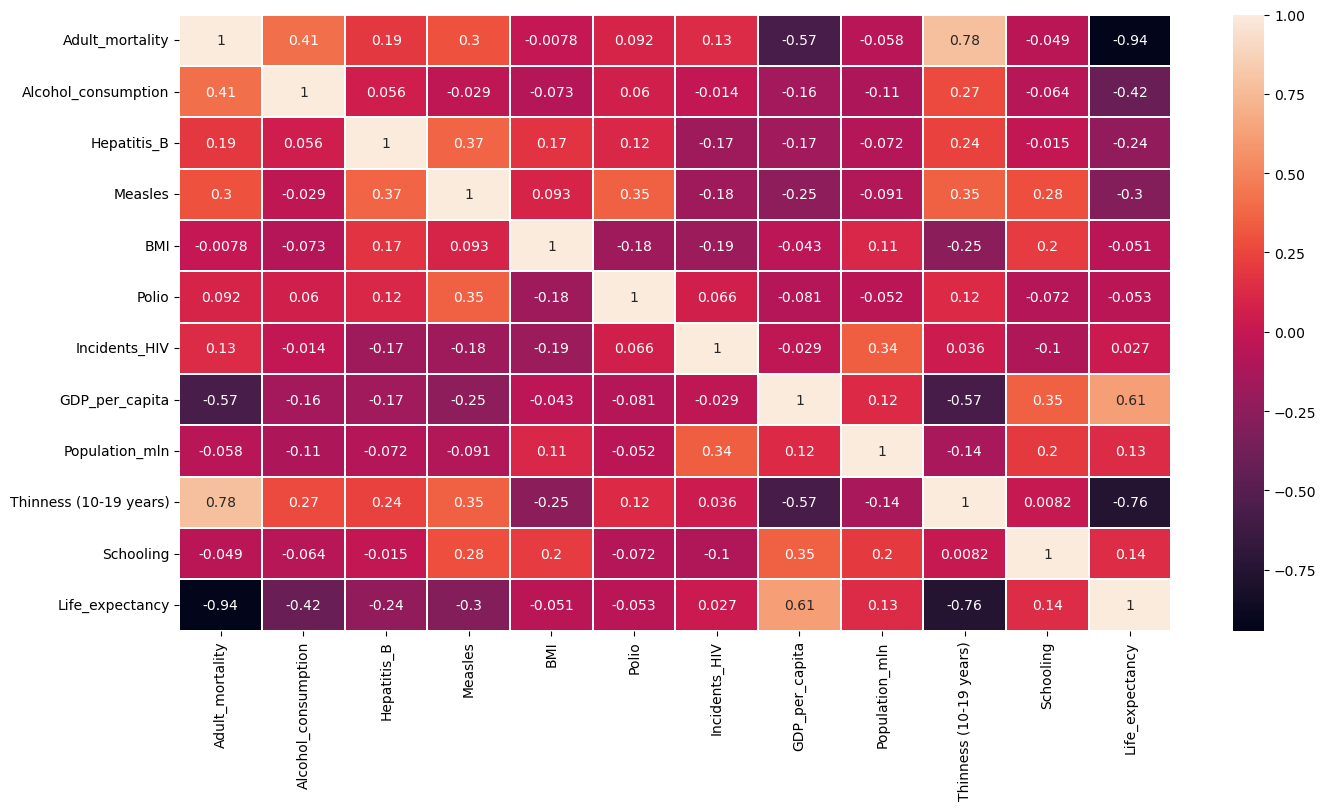

In [32]:
# Developed
corr_heatmap(df_reduced[df_reduced['Developed']==1].drop('Developed', axis=1), ['Country', 'Region', 'Year'])

## More graphs

In [34]:
df_reduced.columns

Index(['Country', 'Region', 'Year', 'Adult_mortality', 'Alcohol_consumption',
       'Hepatitis_B', 'Measles', 'BMI', 'Polio', 'Incidents_HIV',
       'GDP_per_capita', 'Population_mln', 'Thinness (10-19 years)',
       'Schooling', 'Developed', 'Life_expectancy'],
      dtype='object')

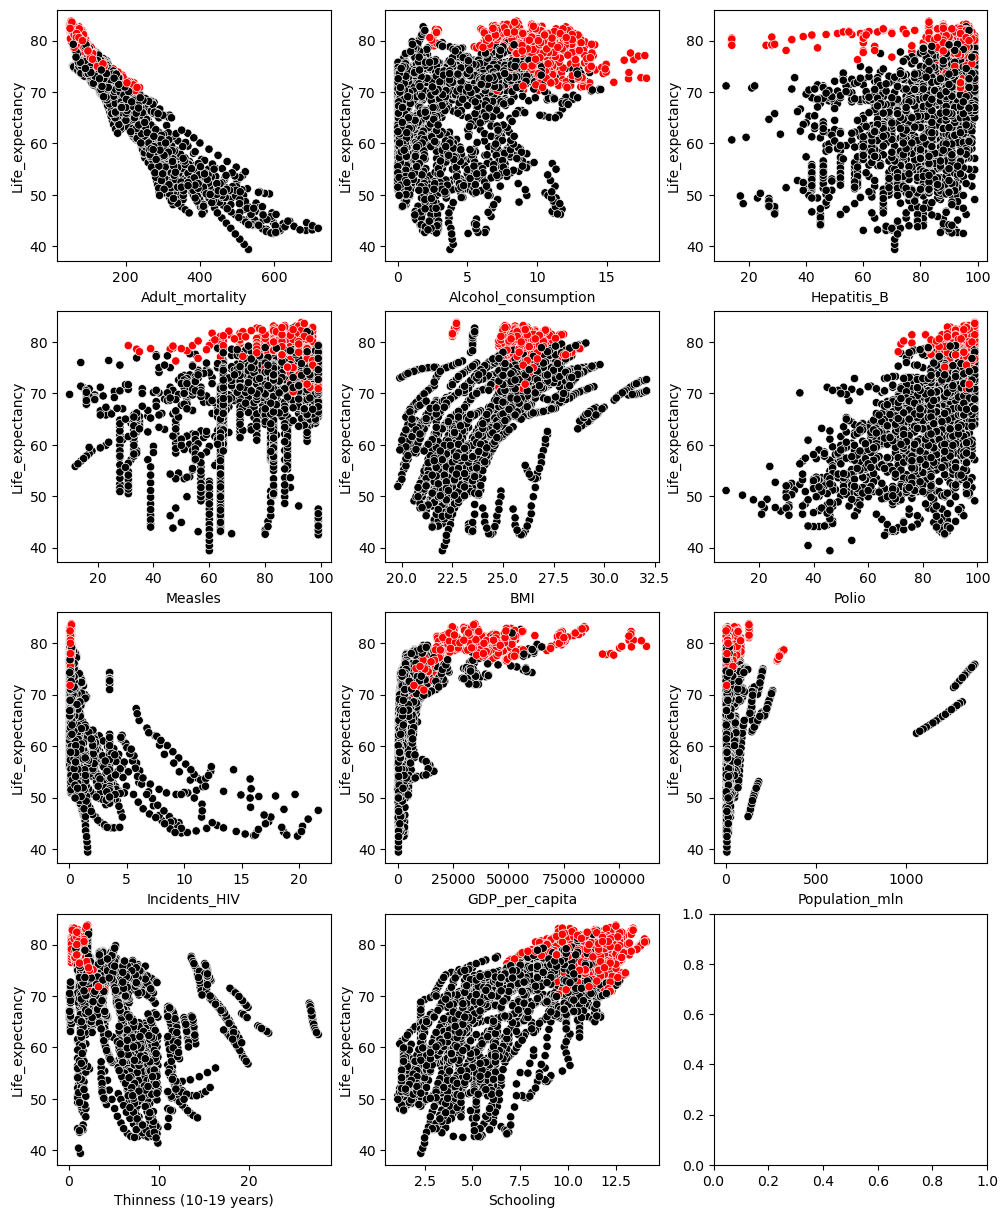

In [35]:
fig, ax = plt.subplots(figsize=(12,15), nrows = 4, ncols=3)

def my_plot(row, col, col_name):
    sns.scatterplot(ax=ax[row, col],
                data=df, 
                x=col_name, 
                y="Life_expectancy",
                hue="Developed",  
                palette=['Black','Red'])
    ax[row, col].legend([],[], frameon=False)

my_plot(0, 0, 'Adult_mortality')
my_plot(0, 1, 'Alcohol_consumption')
my_plot(0, 2, 'Hepatitis_B')

my_plot(1, 0, 'Measles')
my_plot(1, 1, 'BMI')
my_plot(1, 2, 'Polio')

my_plot(2, 0, 'Incidents_HIV')
my_plot(2, 1, 'GDP_per_capita')
my_plot(2, 2, 'Population_mln')
    
my_plot(3, 0, 'Thinness (10-19 years)')
my_plot(3, 1, 'Schooling')
plt.show()